In [1]:
!date

In [2]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [3]:
%%time

import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from helper_funcs import *
import shutil
from scipy.stats import ttest_ind,ttest_1samp,ttest_rel

import umap

CPU times: user 11.1 s, sys: 4.64 s, total: 15.8 s
Wall time: 45.5 s


In [4]:
## BEGIN FUNCTIONS

In [5]:
def fit_rsa(rdm_data,rdm_model,measure='pearson',cov=None):
    from scipy.stats import kendalltau
    from pingouin import partial_corr
    
    if measure=='pearson':
        r = np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
    elif measure=='kendall':
        r = kendalltau(get_triu(rdm_data),get_triu(rdm_model))[0]
    elif measure=='partial_kendall':
        arr = pd.DataFrame(np.array([get_triu(rdm_data),get_triu(rdm_model),get_triu(cov)]).transpose(),columns=['x','y','cv1'])
        r = partial_corr(data=arr, x='x', y='y', covar='cv1')['r'].values[0]
            
    return r

In [6]:
def key_rsa(inMat,key,model_scale,df,return_models=False):
    vec = df[key].values
    e = np.isnan(vec)

    model_rdm = make_RDM(vec[~e],data_scale=model_scale, metric='euclidean')
    models = []
    model_fit = []

    # Make models
    for i in range(len(inMat)):
        mat = inMat[i]['data']
        metric = inMat[i]['metric']
        data_scale = inMat[i]['data_scale']

        if mat.ndim==3:
            model_data = np.array([make_RDM(mat[i,~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        elif mat.ndim==2:
            model_data = np.array([make_RDM(mat[~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        models.append(model_data)

    for m in range(len(models)):
        model_fit.append([fit_rsa(models[m][i,:,:],model_rdm,measure='kendall') for i in range(10)])

    res = np.array(model_fit).transpose()

    if return_models==True:
        return res,models
    else:
        return res

In [7]:
def plot_nice_bar(key,rsa,ax=None,figsize=None,dpi=None,fontsize=None,fontsize_star=None,fontweight=None,line_width=None,marker_size=None,title=None,report_t=False,do_pairwise_stars=False,do_one_sample_stars=True,lbls=['VAE','BG','SL'],match_y=None):
    
    import seaborn as sns
    from scipy.stats import ttest_1samp
    from scipy.stats import ttest_ind as ttest
    
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    
    has_error = rsa_res[key].std(axis=0)>1e-6
    
    if not figsize:
        figsize = (5,2)
    if not dpi:
        dpi = 300
        
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=figsize,dpi=dpi)

    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    data=rsa[key]
    n = data.shape[0]
    c = data.shape[1]
    x = np.arange(c)
    
    if not fontsize:
        fontsize = 16
        
    if not fontsize_star:
        fontsize_star = 25
    if not fontweight:        
        fontweight = 'bold'
    if not line_width:    
        line_width = 2.5
    if not marker_size:            
        marker_size = .1


    for i in range(c):
        plot_data = np.zeros(data.shape)
        plot_data[:,i] = data[:,i]

        xs = np.repeat(i,n)+(np.random.rand(n)-.5)*.25
        
        if has_error[i]==True:
            sc = plt.scatter(xs,data[:,i],c='k',s = marker_size)
        b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
        
        if type(match_y)!=type(None):
            plt.ylim(match_y)

    locs, labels = plt.yticks()  
    new_y = locs
    new_y = np.linspace(locs[0],locs[-1],6)
    plt.yticks(new_y,labels=[f'{yy:.2f}' for yy in new_y],fontsize=fontsize,fontweight=fontweight)
    plt.ylabel('model fit (r)',fontsize=fontsize,fontweight=fontweight)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(line_width)

    xlbls = lbls.copy()
    
    plt.xticks(np.arange(len(xlbls)),labels=xlbls,fontsize=fontsize,fontweight=fontweight)
    
    if do_one_sample_stars:
        one_sample = np.array([ttest_1samp(data[:,i],0) for i in range(len(xlbls))])
        one_sample_thresh = np.array((1,.05,.001,.0001))
        one_sample_stars = np.array(('n.s.','*','**','***'))
        xlbls = lbls.copy()
        for i in range(1,c):
            if has_error[i]==True:
                these_stars = one_sample_stars[max(np.nonzero(one_sample[i,1]<one_sample_thresh)[0])]
                xlbls[i] = f'{xlbls[i]}\n({these_stars})'
        plt.xticks(np.arange(len(xlbls)),labels=xlbls,fontsize=fontsize,fontweight=fontweight,horizontalalignment='center',multialignment='center')

    pairwise_t = np.zeros((3,3))
    pairwise_p = np.zeros((3,3))

    pairwise_sample_thresh = np.array((1,.05,.001,.0001))
    pairwise_sample_stars = np.array(('n.s.','*','**','***'))

    if report_t:
        for i in range(c):
            for j in range(c):
                t,p = ttest(data[:,i],data[:,j])
                mnames = lbls.copy()

                if p > .001:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p = {p:.2f}')
                else:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p $<$ .001')
                pairwise_t[i,j] = t
                pairwise_p[i,j] = p

    comps = [[1,2]]
    if do_pairwise_stars:
        for comp_idx in range(len(comps)):
            this_comp = comps[comp_idx]
            sig_idx = max(np.nonzero(pairwise_p[this_comp[0],this_comp[1]]<pairwise_sample_thresh)[0])
            max_y = new_y[-1] + comp_idx*.05
            xs = np.array(this_comp)
            stars = pairwise_sample_stars[sig_idx]
            plt.plot(xs,[max_y,max_y],'k',linewidth=line_width)
            plt.text(xs.mean(),max_y,stars,fontsize=fontsize_star,horizontalalignment='center',fontweight=fontweight)
        
    ylim = plt.ylim()
    plt.ylim(np.array(ylim)*(1,1.1))
    
    if not title:
        plt.title(key,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)    
    else:
        plt.title(title,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)    
        

In [8]:
def key_rsa_partial(inMat,key,model_scale,df_use,return_models=False,cov=None):
    vec = df_use[key].values
    e = np.isnan(vec)

    model_rdm = make_RDM(vec[~e],data_scale=model_scale, metric='euclidean')
    models = []
    model_fit = []

    # Make models
    for i in range(len(inMat)):
        mat = inMat[i]['data']
        metric = inMat[i]['metric']
        data_scale = inMat[i]['data_scale']

        if mat.ndim==3:
            model_data = np.array([make_RDM(mat[i,~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        elif mat.ndim==2:
            model_data = np.array([make_RDM(mat[~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        models.append(model_data)

    if type(cov)==type(None):
        cov_rdm = make_RDM(df_use['site_id'].values[~e],data_scale='ordinal', metric='euclidean')
    else:
        cov_rdm = make_RDM(cov[~e])
        
    for m in range(len(models)):
        model_fit.append([fit_rsa(models[m][i,:,:],model_rdm,measure='partial_kendall',cov=cov_rdm) for i in range(10)])
        

    res = np.array(model_fit).transpose()

    if return_models==True:
        return res,models
    else:
        return res

In [9]:
def dummy_ordinal(invec):
    unique_values = np.unique(invec)
    new_values = np.arange(1,len(unique_values)+1)
    new_arr = [new_values[val==unique_values][0] for val in invec]
    return new_arr

In [10]:
def flatten_cmat(cmats):
    ns = cmats.shape[0]
    ni = cmats.shape[-1]
    tridx = np.triu_indices(n=ni,k=1)
    mat_flat = np.array([cmats[i,:,:][tridx] for i in range(ns)])
    return mat_flat

In [11]:
# END OF FUNCTIONS

In [12]:
analysis_name = 'CVAE_2022-03-25 18:28:49.469238'
save_dir = os.path.join('../Assets/tf_weights',analysis_name)

In [13]:
# YEO ROI NAMES
rnames = ['LH-Vis-EVC','LH-SomMot-Mot','LH-DorsAttn-Post','LH-DorsAttn-FEF','LH-DorsAttn-PrCv','LH-SalVentAttn-ParOper','LH-SalVentAttn-TempOcc','LH-SalVentAttn-FrOper','LH-SalVentAttn-PFCl','LH-SalVentAttn-Med','LH-Limbic-OFC','LH-Limbic-TempPole','LH-Cont-Par','LH-Cont-Temp','LH-Cont-PFCd','LH-Cont-PFCl','LH-Cont-OFC','LH-Cont-PFCv','LH-Cont-pCun','LH-Cont-Cing','LH-Cont-PFCmp','LH-Default-Par','LH-Default-Temp','LH-Default-PFC','LH-Default-PCC','LH-Default-PHC','RH-Vis-EVC','RH-SomMot-Mot','RH-DorsAttn-Post','RH-DorsAttn-FEF','RH-DorsAttn-PrCv','RH-SalVentAttn-TempOccPar','RH-SalVentAttn-PrC','RH-SalVentAttn-FrOper','RH-SalVentAttn-PFCv','RH-SalVentAttn-PFCl','RH-SalVentAttn-Med','RH-Limbic-OFC','RH-Limbic-TempPole','RH-Cont-Par','RH-Cont-Temp','RH-Cont-PFCv','RH-Cont-PFCl','RH-Cont-pCun','RH-Cont-Cing','RH-Cont-PFCmp','RH-Default-Par','RH-Default-Temp','RH-Default-PFCv','RH-Default-PFCm','RH-Default-PCC']

In [14]:
df = pd.read_csv('../Data/comb_df.csv')
df['dataset_id'] = dummy_ordinal(df['dataset'])
df['site_id'] = dummy_ordinal(df['site'])


u_sites = np.unique(df['site_id'].values)
sites = df['site_id'].values.astype(float)
site_ratios = np.array([(df['diag'].values[df['site_id'].values==s]==1).mean() for s in u_sites])
bad_sites = u_sites[abs(site_ratios-.5)>.1]
sites[df['site_id'].isin(bad_sites).values] = np.nan
df['sites_bal'] = sites
print((~np.isnan(df['sites_bal'].values)).sum())


patients = df['diag'].values==1
df_asd = df.iloc[patients]
df_td = df.iloc[~patients]

print(df_asd.shape)
print(df_td.shape)

df

1025
(661, 16)
(841, 16)


,Unnamed: 0,participant_id,diag,age,sex,fiq,site,DSMIV,ados_total,ados_social,ados_comm,ados_rrb,dataset,dataset_id,site_id,sites_bal
0,0,50002,1,16.77,1,103.0,13,1.0,12.0,8.0,4.0,3.0,ABIDE I,1,4,4.0
1,2,50004,1,19.09,1,113.0,13,1.0,18.0,12.0,6.0,2.0,ABIDE I,1,4,4.0
2,3,50005,1,13.73,2,119.0,13,1.0,12.0,8.0,4.0,1.0,ABIDE I,1,4,4.0
3,4,50006,1,13.37,1,109.0,13,1.0,12.0,8.0,4.0,4.0,ABIDE I,1,4,4.0
4,9,50011,1,16.93,1,111.0,13,1.0,13.0,9.0,4.0,NaN,ABIDE I,1,4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,746,30163,2,8.00,2,136.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29,NaN
1498,747,30164,2,10.00,2,115.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29,NaN
1499,748,30165,2,12.00,2,120.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29,NaN
1500,749,30166,2,10.00,2,112.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29,NaN


In [15]:
## Load Data
cmats = np.load('../Data/cmats_r51_S1502.npz')['data']
cmats_rel = np.load('../Data/rel-cmats_r51_S1502.npz')['data']
cmats_asd_flat = flatten_cmat(cmats[patients,:,:])

print(cmats.shape)
print(cmats_rel.shape)
print(cmats_asd_flat.shape)

(1502, 51, 51)
(1502, 2, 51, 51)
(661, 1275)


In [16]:
def depad(mat,idx=(6,57)):
    'depads the cmats'
    if mat.ndim==3:
        mat_trimmed = mat[:,idx[0]:idx[1],idx[0]:idx[1]]
    elif mat.ndim==4:
        mat_trimmed = mat[:,:,idx[0]:idx[1],idx[0]:idx[1]]
    else:
        print(mat.shape)
        raise Exception("Not implemented")
        
    return mat_trimmed

In [17]:
def plot_scatterbar(inData,lbls):
#inData = [v1,v2]
#lbls = ['LH','RH']
    n = len(inData)

    plt.bar(np.arange(n),[v.mean() for v in inData],alpha=.5)

    for i in range(n):
        ys = inData[i]
        xs = np.ones(ys.shape)*i
        xs = xs+(np.random.rand(xs.shape[0])-.5)*.1
        plt.scatter(xs,ys);

    plt.xticks(np.arange(n),labels=lbls);

In [18]:
%%time

data = np.load(os.path.join(save_dir,'results.npz'))
data = dict(data)
data_keys = list(data.keys())

# Z_mu = data['Z_mu']
# Z_sigma = data['Z_sigma']
# Z = data['Z']
# S_mu = data['S_mu']
# S_sigma = data['S_sigma']
# S = data['S']
# Z_sample100 = data['Z_sample100']
# S_sample100 = data['S_sample100']

data['recon_td_mu'] = depad(data['recon_td_mu'])
data['recon_asd_mu'] = depad(data['recon_asd_mu'])
data['recon_twin_mu'] = depad(data['recon_twin_mu'])
data['recon_td_samples'] = depad(data['recon_td_samples'])
data['recon_asd_samples'] = depad(data['recon_asd_samples'])
data['recon_twin_samples'] = depad(data['recon_twin_samples'])

data['Z_asd_sample10'] = data['Z_sample100'][0:10,patients,:]
data['S_asd_sample10'] = data['S_sample100'][0:10,patients,:]

for key in data_keys:
    print(f'{key.center(20)} | {data[key].shape}')

        Z_mu         | (1502, 16)
      Z_sigma        | (1502, 16)
         Z           | (1502, 16)
        S_mu         | (1502, 16)
      S_sigma        | (1502, 16)
         S           | (1502, 16)
    Z_sample100      | (100, 1502, 16)
    S_sample100      | (100, 1502, 16)
    recon_td_mu      | (841, 51, 51)
    recon_asd_mu     | (661, 51, 51)
   recon_twin_mu     | (661, 51, 51)
  recon_td_samples   | (100, 841, 51, 51)
 recon_asd_samples   | (100, 661, 51, 51)
 recon_twin_samples  | (100, 661, 51, 51)
CPU times: user 20.9 s, sys: 932 ms, total: 21.8 s
Wall time: 21.9 s


In [19]:
v1 = ((cmats[patients,:,:]-data['recon_asd_mu'])**2).mean(axis=-1).mean(axis=-1)
v2 = ((cmats[~patients,:,:]-data['recon_td_mu'])**2).mean(axis=-1).mean(axis=-1)
v3 = ((cmats[patients,:,:]-data['recon_twin_mu'])**2).mean(axis=-1).mean(axis=-1)

/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


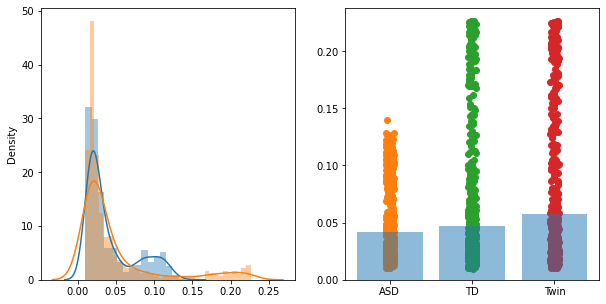

In [20]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(v1)
sns.distplot(v2)
plt.subplot(1,2,2)
plot_scatterbar([v1,v2,v3],['ASD','TD','Twin'])

In [21]:
ttest_ind(v1,v2)

Ttest_indResult(statistic=-2.484322707191519, pvalue=0.013088231401197014)

In [22]:
def get_fd(sub):
    '''takes in a sub, returns average FD'''
    if df.loc[df['participant_id'] == sub]['dataset_id'].values[0]==2:
        temp = f'~/data/ABIDE2/Derivatives/preprocessed/sub-{sub}'
        temp = os.path.expanduser(temp)
        folders = os.listdir(temp)
        folders.sort()
        csv = [file for file in os.listdir(os.path.join(temp,folders[0])) if file.endswith('csv')]
        mot = pd.read_csv(os.path.join(os.path.join(temp,folders[0],csv[0])))
        
        #fd = np.nanmean(mot['framewise_displacement'].values)
        fd = np.nansum(mot['framewise_displacement'].values)
        
    elif df.loc[df['participant_id'] == sub]['dataset_id'].values[0]==1:
        conf_fn = '~/data/ABIDE/Derivatives/preprocessed/sub-00{sub}/conf-sub-00{sub}.csv'
        temp = pd.read_csv(conf_fn.format(sub=sub))
        
        #fd = np.nanmean(temp['framewise_displacement'].values)
        fd = np.nansum(temp['framewise_displacement'].values)
    return fd

FDs = np.array([get_fd(subID) for subID in tqdm(df['participant_id'].values[patients])])
df_asd['FDs'] = FDs

100%|██████████| 661/661 [00:26<00:00, 24.94it/s]
<ipython-input-22-209e2f33c74b>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asd['FDs'] = FDs


In [23]:
FDs_td = np.array([get_fd(subID) for subID in tqdm(df['participant_id'].values[~patients])])

100%|██████████| 841/841 [00:33<00:00, 25.28it/s]


/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Framewise Displacement by group')

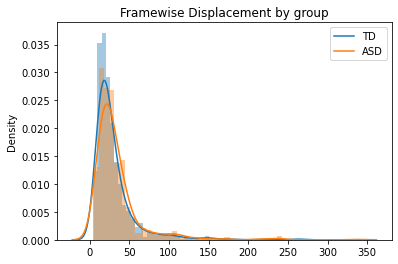

In [24]:
sns.distplot(FDs_td)
sns.distplot(FDs)
plt.legend(['TD','ASD'])
plt.title('Framewise Displacement by group')

In [25]:
def pretty_t_ind(v1,v2,return_statement=False):
    from scipy.stats import ttest_ind
    degf = len(v1)+len(v2)-2
    t,p = ttest_ind(v2,v1)

    if p<.001:
        t_statement = f't({degf}) = {t:.2f}, p < .001'
    else:
        t_statement = f't({degf}) = {t:.2f}, p = {p:.2}'
    if return_statement==True:
        return t_statement
    else:
        print(t_statement)

In [26]:
pretty_t_ind(FDs,FDs_td)

t(1500) = -2.53, p = 0.011


In [27]:
data.keys()

dict_keys(['Z_mu', 'Z_sigma', 'Z', 'S_mu', 'S_sigma', 'S', 'Z_sample100', 'S_sample100', 'recon_td_mu', 'recon_asd_mu', 'recon_twin_mu', 'recon_td_samples', 'recon_asd_samples', 'recon_twin_samples', 'Z_asd_sample10', 'S_asd_sample10'])

/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

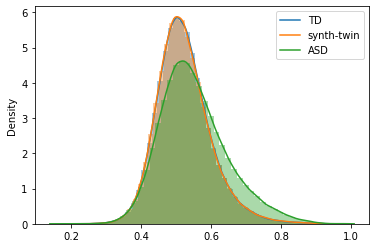

In [28]:
sns.distplot(flatten_cmat(data['recon_td_mu']))
sns.distplot(flatten_cmat(data['recon_twin_mu']))
sns.distplot(flatten_cmat(data['recon_asd_mu']))
plt.legend(['TD','synth-twin', 'ASD'])

In [29]:
diffmat = (data['recon_asd_mu']-data['recon_twin_mu'])
diffmat_flat = flatten_cmat(diffmat)

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
FDs.shape

(661,)

In [32]:
diffmat_resid = np.array([diffmat_flat[:,i][:,np.newaxis]-LinearRegression().fit(FDs[:,np.newaxis] , diffmat_flat[:,i][:,np.newaxis]).predict(FDs[:,np.newaxis]) for i in range(diffmat_flat.shape[1])])
diffmat_resid = diffmat_resid[:,:,0].transpose()
diffmat_resid.shape

(661, 1275)

In [33]:
v1 = {'label' : 'CMAT', 'data' : cmats_asd_flat, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v2 = {'label' : 'DMAT', 'data' : diffmat_flat, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v3 = {'label' : 'BG', 'data' : data['Z_asd_sample10'], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v4 = {'label' : 'SL', 'data' : data['S_asd_sample10'], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v5 = {'label' : 'FDs', 'data' : FDs[:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v6 = {'label' : 'DR', 'data' : diffmat_resid, 'data_scale' : 'ratio', 'metric' : 'euclidean'}

In [34]:
#inMat = [v1,v2,v3,v4,v5]
inMat = [v1,v2,v6]

In [35]:
rsa_res = dict()
keys = ['dataset_id', 'sites_bal','age', 'sex', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb']
data_scale = ['ordinal', 'ordinal','ratio', 'ordinal', 'ratio','ordinal','ratio', 'ratio', 'ratio', 'ratio']

for i in tqdm(range(len(keys))):
    rsa_res.update({keys[i] : key_rsa(inMat,keys[i],df=df_asd,model_scale=data_scale[i])})

  0%|          | 0/10 [00:00<?, ?it/s]/data/aglinska/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/data/aglinska/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
100%|██████████| 10/10 [01:33<00:00,  9.34s/it]


In [36]:
rsa_res2 = dict()
keys = ['dataset_id', 'sites_bal','age', 'sex', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb']
data_scale = ['ordinal', 'ordinal','ratio', 'ordinal', 'ratio','ordinal','ratio', 'ratio', 'ratio', 'ratio']

for i in tqdm(range(len(keys))):
    rsa_res2.update({keys[i] : key_rsa_partial(inMat,keys[i],df_use=df_asd,model_scale=data_scale[i])})

100%|██████████| 10/10 [01:30<00:00,  9.01s/it]


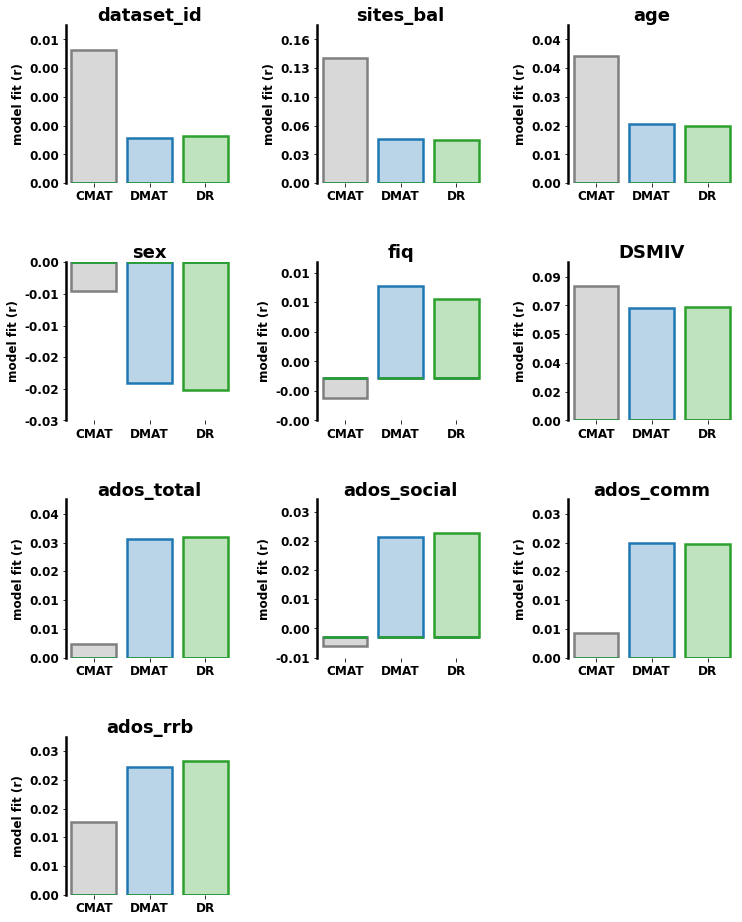

In [37]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))
plt.figure(figsize=np.array((ncols,nrows))*4)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_res,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=keys[i],lbls=[inMat[j]['label'] for j in range(len(inMat))])
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

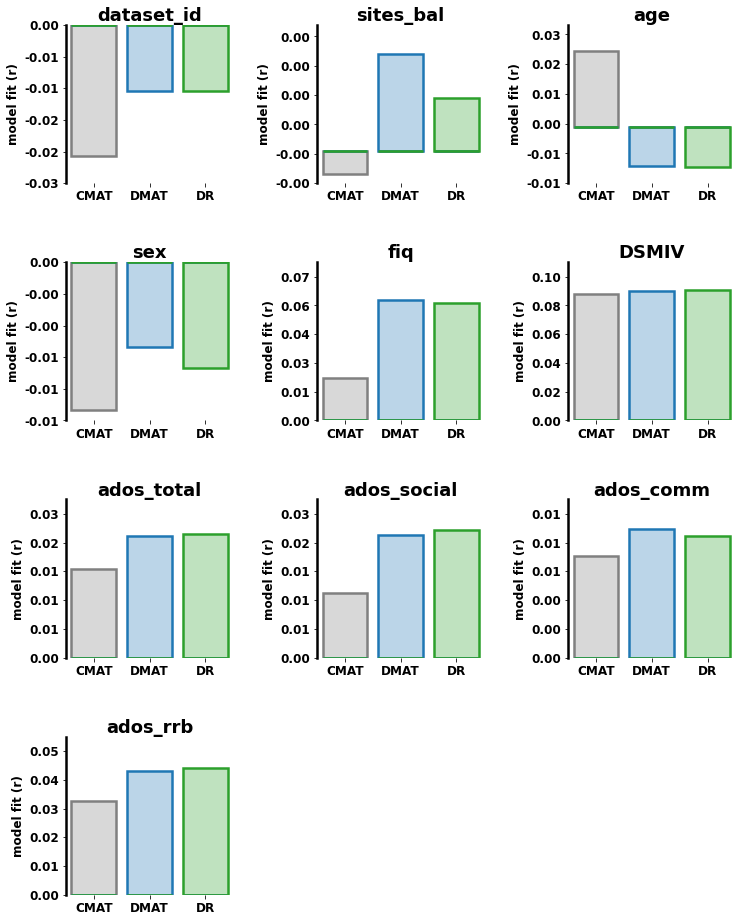

In [38]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))
plt.figure(figsize=np.array((ncols,nrows))*4)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_res2,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=keys[i],lbls=[inMat[j]['label'] for j in range(len(inMat))])
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

In [39]:
td1 = {'label' : 'CMAT', 'data' : flatten_cmat(cmats[~patients,:,:]), 'data_scale' : 'ratio', 'metric' : 'euclidean'}
td2 = {'label' : 'BG', 'data' : data['Z_mu'][~patients,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
td3 = {'label' : 'SL', 'data' : data['S_mu'][~patients,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
tdMat = [td1,td2,td3]

rsa_res_td = dict()
keys = ['dataset_id', 'sites_bal','age', 'sex', 'fiq']
data_scale = ['ordinal', 'ordinal','ratio', 'ordinal', 'ratio']

for i in tqdm(range(len(keys))):
    rsa_res_td.update({keys[i] : key_rsa(tdMat,keys[i],df=df.iloc[~patients],model_scale=data_scale[i])})

100%|██████████| 5/5 [00:33<00:00,  6.70s/it]


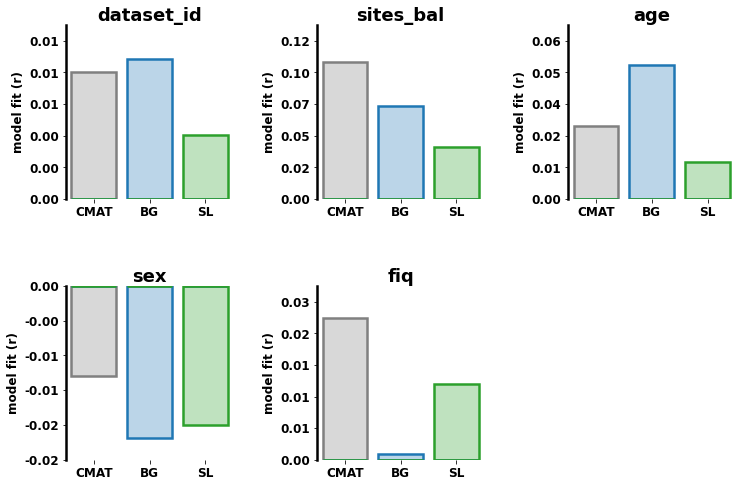

In [40]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))
plt.figure(figsize=np.array((ncols,nrows))*4)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_res_td,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=keys[i],lbls=[tdMat[j]['label'] for j in range(len(tdMat))])
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

In [41]:
from sklearn.linear_model import LogisticRegression,LinearRegression,ElasticNet,Ridge
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

In [42]:
### PCA

In [43]:
diffmat_asd_flat = flatten_cmat(diffmat)
diffmat_asd_flat.shape

(661, 1275)

In [44]:
reducer = PCA()
comps = reducer.fit_transform(diffmat_asd_flat)
#comps = UMAP(n_components=10).fit_transform(diffmat_asd_flat)
#comps = reducer.fit_transform(cmats_asd_flat)
comps.shape

(661, 661)

In [45]:
(reducer.explained_variance_ratio_[0:10]*100).round(2)

array([44.74,  3.59,  2.66,  2.47,  2.22,  1.92,  1.7 ,  1.39,  1.28,
        1.15], dtype=float32)

In [46]:
diffmat_asd_flat.shape

(661, 1275)

In [47]:
#inMat = diffmat_asd_flat
inMat = diffmat_resid
n = inMat.shape[0]
loso_comp = np.array([PCA().fit(inMat[np.arange(n)!=s,:]).transform(inMat[s,:][np.newaxis,:]) for s in tqdm(range(n))])

100%|██████████| 661/661 [17:01<00:00,  1.54s/it]  


In [48]:
loso_comp.shape

(661, 1, 660)

In [49]:
comps = loso_comp[:,0,:]

In [50]:
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr

In [51]:
v1 = {'label' : 'PC1', 'data' : comps[:,0][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v2 = {'label' : 'PC2', 'data' : comps[:,1][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v3 = {'label' : 'PC3', 'data' : comps[:,2][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v4 = {'label' : 'PC4', 'data' : comps[:,3][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v5 = {'label' : 'PC5', 'data' : comps[:,4][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v6 = {'label' : 'PC6', 'data' : comps[:,5][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v7 = {'label' : 'PC7', 'data' : comps[:,6][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v8 = {'label' : 'PC8', 'data' : comps[:,7][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v9 = {'label' : 'PC9', 'data' : comps[:,8][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v10 = {'label' : 'PC10', 'data' : comps[:,9][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}

In [52]:
inMat = [v1,v2,v3,v4,v5,v6,v7,v8,v9,v10]

In [53]:
rsa_res = dict()
rsa_res_partial = dict()
keys = ['dataset_id', 'sites_bal','age', 'sex', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb','FDs']
data_scale = ['ordinal', 'ordinal','ratio', 'ordinal', 'ratio','ordinal','ratio', 'ratio', 'ratio', 'ratio','ratio']
#cov = make_RDM(FDs)
for i in tqdm(range(len(keys))):
    rsa_res.update({keys[i] : key_rsa(inMat,keys[i],df=df_asd,model_scale=data_scale[i])})
    rsa_res_partial.update({keys[i] : key_rsa_partial(inMat,keys[i],df_use=df_asd,model_scale=data_scale[i],cov=None)})

100%|██████████| 11/11 [01:18<00:00,  7.14s/it]


Text(0.5, 0.98, 'FDs NOT partialled out')

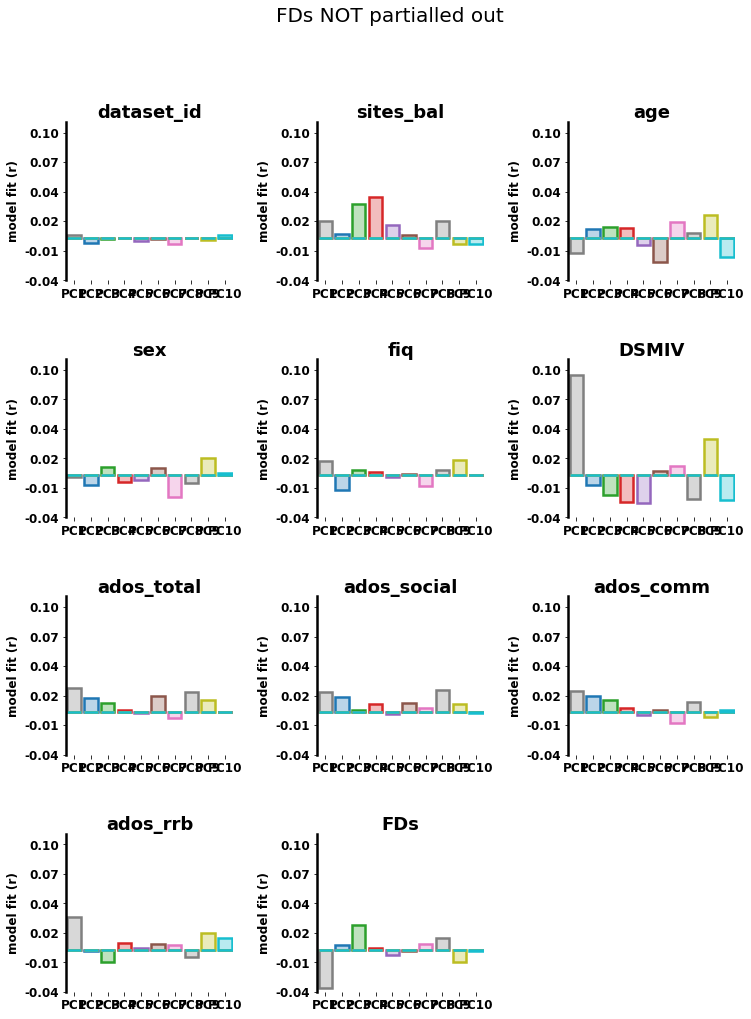

In [54]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))
plt.figure(figsize=np.array((ncols,nrows))*4)

temp = np.array([rsa_res[k] for k in list(rsa_res.keys())])
ylim = (temp.min(),temp.max())

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_res,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,
                  title=keys[i],
                  lbls=[inMat[j]['label'] for j in range(len(inMat))],
                  match_y=ylim
                 )
    
plt.subplots_adjust(
    left=None,
    bottom= None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

plt.suptitle('FDs NOT partialled out',fontsize=20)

Text(0.5, 0.98, 'FDs partialled out')

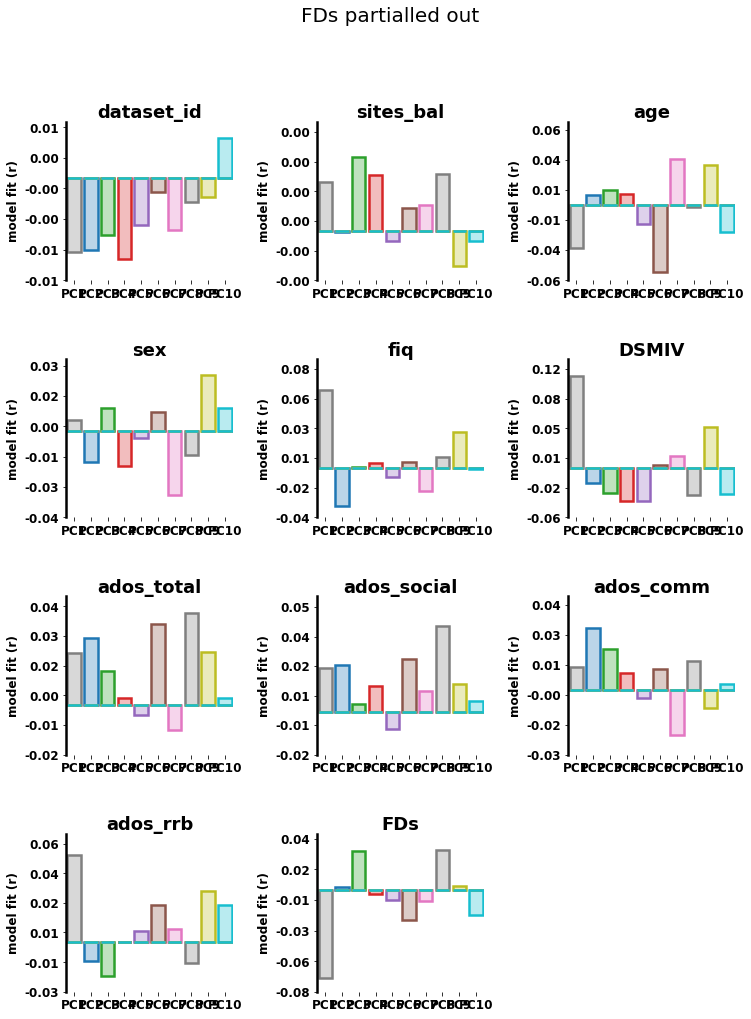

In [55]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))
plt.figure(figsize=np.array((ncols,nrows))*4)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_res_partial,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=keys[i],lbls=[inMat[j]['label'] for j in range(len(inMat))])
    
plt.subplots_adjust(
    left=None,
    bottom= None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

plt.suptitle('FDs partialled out',fontsize=20)

In [56]:
diffmat_resid

array([[ 0.06558158, -0.06823967, -0.13743591, ..., -0.15535648,
        -0.16682571, -0.05920864],
       [-0.0769217 , -0.04965516, -0.05221192, ..., -0.03707417,
        -0.0331011 ,  0.00674489],
       [-0.01309259, -0.01614308,  0.00808644, ..., -0.02952873,
        -0.08030891, -0.11324507],
       ...,
       [ 0.00733943, -0.07498807, -0.03124974, ..., -0.13517197,
        -0.05466856,  0.02267994],
       [ 0.03023623,  0.15498422,  0.08541494, ..., -0.14650205,
        -0.0094381 ,  0.11895456],
       [-0.15888548, -0.07848205, -0.06149358, ..., -0.05479639,
        -0.05819189, -0.03505611]])

In [57]:
r01 = np.array([pearsonr(diffmat_resid[:,i],comps[:,0]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r02 = np.array([pearsonr(diffmat_resid[:,i],comps[:,1]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r03 = np.array([pearsonr(diffmat_resid[:,i],comps[:,2]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r04 = np.array([pearsonr(diffmat_resid[:,i],comps[:,3]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r05 = np.array([pearsonr(diffmat_resid[:,i],comps[:,4]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r06 = np.array([pearsonr(diffmat_resid[:,i],comps[:,5]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r07 = np.array([pearsonr(diffmat_resid[:,i],comps[:,6]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r08 = np.array([pearsonr(diffmat_resid[:,i],comps[:,7]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r09 = np.array([pearsonr(diffmat_resid[:,i],comps[:,8]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r10 = np.array([pearsonr(diffmat_resid[:,i],comps[:,9]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])

100%|██████████| 1275/1275 [00:00<00:00, 22579.16it/s]


<AxesSubplot:>

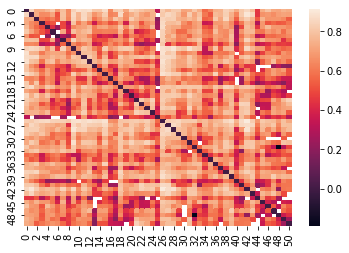

In [58]:
vec = r01
mat1 = squareform(vec[:,0])
mat1[squareform(vec[:,1])>.05/1275/10] = np.nan
sns.heatmap(mat1)

In [59]:
# ys = np.nansum((mat1)>0,axis=0)
# xs = np.arange(len(ys))
# lbls = np.array(rnames)

# ys = ys[I]
# lbls = lbls[I]

# plt.figure(figsize=(25,5))
# plt.bar(xs,ys,alpha=.5)
# plt.xticks(xs,labels=lbls,rotation=90);

# ys = np.nansum((mat1)<0,axis=0)
# xs = np.arange(len(ys))
# plt.bar(xs,ys,alpha=.5)
# plt.xticks(xs,labels=lbls,rotation=90);

# plt.legend(['over-connected','under-connected'])

In [60]:
rlbls = pd.DataFrame()
rlbls['rname'] = rnames
rlbls['hem'] = [val.split('-')[0] for val in rnames]
rlbls['net'] = [val.split('-')[1] for val in rnames]
rlbls['roi'] = [val.split('-')[2] for val in rnames]
rlbls['idx'] = np.arange(51)
rlbls.head()

,rname,hem,net,roi,idx
0,LH-Vis-EVC,LH,Vis,EVC,0
1,LH-SomMot-Mot,LH,SomMot,Mot,1
2,LH-DorsAttn-Post,LH,DorsAttn,Post,2
3,LH-DorsAttn-FEF,LH,DorsAttn,FEF,3
4,LH-DorsAttn-PrCv,LH,DorsAttn,PrCv,4


In [61]:
from mne.viz import circular_layout
from mne.viz.circle import _plot_connectivity_circle

In [62]:
node_order = rnames
label_names = rnames

In [63]:
def plot_connGraph(plot_mat,ax=None,n_lines=None,colormap='bwr',title=None,vmin=None,vmax=None):
    
    #plot_mat = mat1
    rnames = ['LH-Vis-EVC','LH-SomMot-Mot','LH-DorsAttn-Post','LH-DorsAttn-FEF','LH-DorsAttn-PrCv','LH-SalVentAttn-ParOper','LH-SalVentAttn-TempOcc','LH-SalVentAttn-FrOper','LH-SalVentAttn-PFCl','LH-SalVentAttn-Med','LH-Limbic-OFC','LH-Limbic-TempPole','LH-Cont-Par','LH-Cont-Temp','LH-Cont-PFCd','LH-Cont-PFCl','LH-Cont-OFC','LH-Cont-PFCv','LH-Cont-pCun','LH-Cont-Cing','LH-Cont-PFCmp','LH-Default-Par','LH-Default-Temp','LH-Default-PFC','LH-Default-PCC','LH-Default-PHC','RH-Vis-EVC','RH-SomMot-Mot','RH-DorsAttn-Post','RH-DorsAttn-FEF','RH-DorsAttn-PrCv','RH-SalVentAttn-TempOccPar','RH-SalVentAttn-PrC','RH-SalVentAttn-FrOper','RH-SalVentAttn-PFCv','RH-SalVentAttn-PFCl','RH-SalVentAttn-Med','RH-Limbic-OFC','RH-Limbic-TempPole','RH-Cont-Par','RH-Cont-Temp','RH-Cont-PFCv','RH-Cont-PFCl','RH-Cont-pCun','RH-Cont-Cing','RH-Cont-PFCmp','RH-Default-Par','RH-Default-Temp','RH-Default-PFCv','RH-Default-PFCm','RH-Default-PCC']
    plot_lbls = rnames

    I = np.hstack((np.arange(25,-1,-1),np.arange(26,51,1)))

    plot_mat = plot_mat[I,:][:,I]
    plot_lbls = np.array(plot_lbls)[I]

    net_colors = dict()
    net_colors['Vis'] = np.array((147,74,146))/ 255
    net_colors['SomMot'] = np.array((103,144,180))/ 255
    net_colors['DorsAttn'] = np.array((50,142,60))/ 255
    net_colors['SalVentAttn'] = np.array((184,102,169))/ 255
    net_colors['Limbic'] = np.array((247,250,201))/ 255
    net_colors['Cont'] = np.array((243,177,82))/ 255
    net_colors['Default'] = np.array((225,99,114)) / 255

    nets = np.array([val.split('-')[1] for val in plot_lbls])
    rois = np.array([val.split('-')[2] for val in plot_lbls])

    node_colors = np.array([net_colors[net] for net in nets ])

    node_angles = circular_layout(label_names, node_order, start_pos=90,
                                  group_boundaries=[0, 26])
    
    _plot_connectivity_circle(con=plot_mat,
            node_names=rois,
            indices=None,
            n_lines=n_lines,
            node_angles=node_angles,
            node_width=None,
            node_height=None,
            node_colors=node_colors,
            facecolor='black',
            textcolor='white',
            node_edgecolor='black',
            linewidth=1.5,
            colormap=colormap,
            vmin=vmin,
            vmax=vmax,
            colorbar=True,
            title=title,
            colorbar_size=.5,
            colorbar_pos=None,
            fontsize_title=12,
            fontsize_names=12,
            fontsize_colorbar=8,
            padding=2.0,
            ax=ax,
            interactive=True,
            node_linewidth=4.0,
            show=True)

In [64]:
# Correlation between motion and diff
pearsonr((diffmat_asd_flat**2).mean(axis=1),FDs)

(-0.034375230063693335, 0.37757542671951483)

In [65]:
# Correlation between motion and diff
pearsonr((diffmat_asd_flat**2).sum(axis=1),FDs)

(-0.03437523040897636, 0.3775754219253681)

In [66]:
for i in range(5):
    print(pearsonr(comps[:,i],FDs))

(-2.1170639108807586e-05, 0.9995665370712485)
(-0.00010275847241974709, 0.9978960512770345)
(-0.0011195989694185796, 0.9770796684042731)
(-5.370762339151165e-05, 0.9989003516893719)
(0.0027071481375522295, 0.9446163428135687)


In [67]:
for i in range(5):
    print(pearsonr(PCA().fit_transform(cmats_asd_flat)[:,i],FDs))

(-0.0265082218031992, 0.4962804087922899)
(0.16516172112902755, 1.9758751795306065e-05)
(0.025843518841175077, 0.5071461176074004)
(-0.0004191049796073189, 0.9914191070957121)
(0.050236886671640266, 0.19706582435257336)


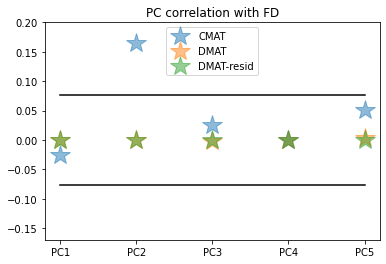

In [68]:
plt.plot([pearsonr(PCA().fit_transform(cmats_asd_flat)[:,i],FDs)[0] for i in range(5)],'*',markersize=20,alpha=.5);
plt.plot([pearsonr(comps[:,i],FDs)[0] for i in range(5)],'*',markersize=20,alpha=.5);
plt.plot([pearsonr(PCA().fit_transform(diffmat_resid)[:,i],FDs)[0] for i in range(5)],'*',markersize=20,alpha=.5);
plt.plot([0,1,2,3,4],[.076,.076,.076,.076,.076],'k-');
plt.plot([0,1,2,3,4],[-.076,-.076,-.076,-.076,-.076],'k-');
plt.title('PC correlation with FD');
plt.xticks(np.arange(5),labels=['PC1','PC2','PC3','PC4','PC5']);
plt.ylim((-.17,.2))
plt.legend(['CMAT','DMAT','DMAT-resid'],loc='upper center')

In [69]:
pearsonr(PCA().fit_transform(cmats_asd_flat)[:,0],FDs)

(-0.0265082218031992, 0.4962804087922899)

In [70]:
pearsonr(PCA().fit_transform(cmats_asd_flat)[:,2],FDs)

(0.025843518841175077, 0.5071461176074004)

In [71]:
abs(vec[:,1]).max()

0.7973179235146071

In [72]:
vec = r01
mat1 = squareform(vec[:,0])

(array([  3.,   2.,  14.,  37.,  71., 115., 204., 325., 364., 140.]),
 array([-0.18884843, -0.07856135,  0.03172573,  0.14201281,  0.25229989,
         0.36258697,  0.47287405,  0.58316113,  0.69344821,  0.80373529,
         0.91402237]),
 <BarContainer object of 10 artists>)

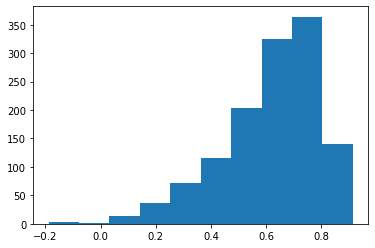

In [73]:
plt.hist(get_triu(mat1))

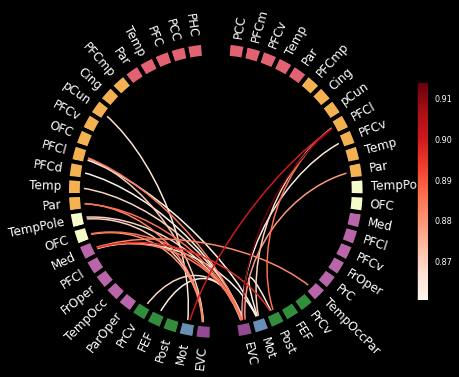

In [74]:
vec = r01
mat1 = squareform(vec[:,0])
#mat1[squareform(vec[:,1])>.05/1275] = np.nan
plot_connGraph(mat1,colormap='Reds',n_lines=25)

/data/aglinska/.local/lib/python3.8/site-packages/mne/viz/circle.py:220: RuntimeWarning: invalid value encountered in greater_equal
  con_draw_idx = np.where(con_abs >= con_thresh)[0]


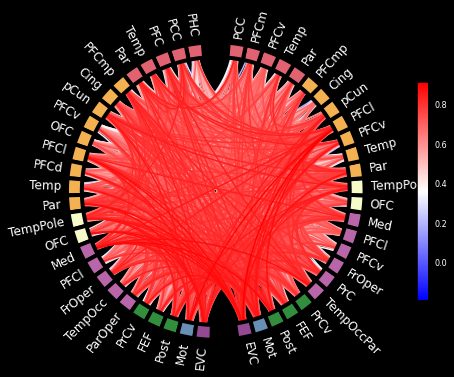

In [75]:
vec = r01
#mat1 = squareform(vec[:,0])
mat1[squareform(vec[:,1])>.05/1275] = np.nan
plot_connGraph(mat1,colormap='bwr')

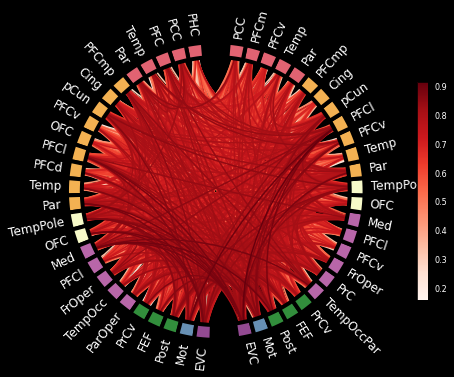

In [76]:
vec = r01
mat1 = squareform(vec[:,0])
mat1[mat1<0] = np.nan
mat1[squareform(vec[:,1])>.05/1275] = np.nan
plot_connGraph(mat1,colormap='Reds')

/data/aglinska/.local/lib/python3.8/site-packages/mne/viz/circle.py:267: RuntimeWarning: invalid value encountered in true_divide
  con_val_scaled = (con - vmin) / vrange


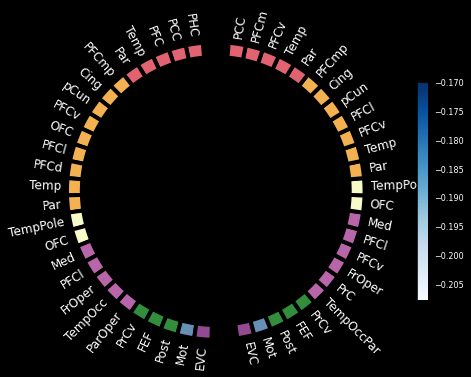

In [77]:
vec = r01
mat1 = squareform(vec[:,0])
mat1[mat1>0] = np.nan
mat1[squareform(vec[:,1])>.05/1275] = np.nan
plot_connGraph(mat1,colormap='Blues')

(array([  8.,  47., 105., 209., 294., 253., 179., 111.,  52.,  17.]),
 array([-0.48582199, -0.38065846, -0.27549493, -0.1703314 , -0.06516787,
         0.03999566,  0.14515919,  0.25032272,  0.35548626,  0.46064979,
         0.56581332]),
 <BarContainer object of 10 artists>)

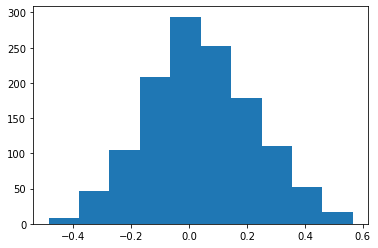

In [78]:
vec = r02
mat1 = squareform(vec[:,0])
plt.hist(get_triu(mat1))

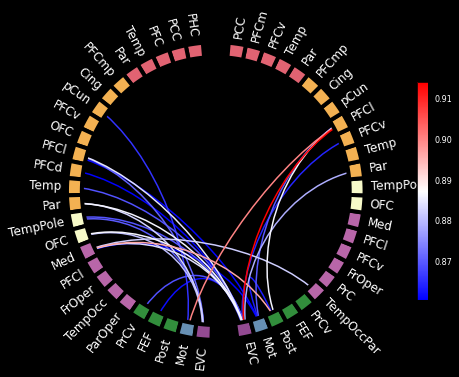

In [79]:
vec = r01
mat1 = squareform(vec[:,0])
#mat1[squareform(vec[:,1])>.05/1275] = np.nan
plot_connGraph(mat1,colormap='bwr',n_lines=25)

<AxesSubplot:>

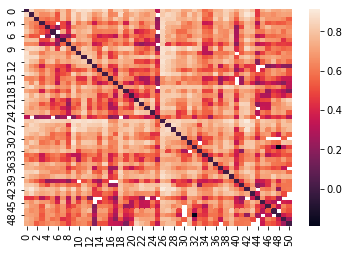

In [80]:
vec = r01
mat1 = squareform(vec[:,0])
mat1[squareform(vec[:,1])>.05/1275] = np.nan
sns.heatmap(mat1)

<AxesSubplot:>

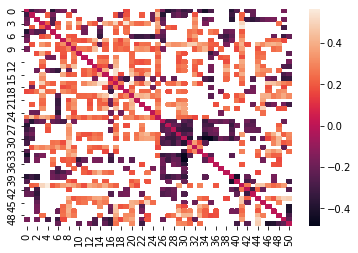

In [81]:
vec = r02
mat1 = squareform(vec[:,0])
mat1[squareform(vec[:,1])>.05/1275] = np.nan
sns.heatmap(mat1)

(array([ 19., 107., 371., 641., 682., 480., 219.,  67.,  11.,   4.]),
 array([-0.03801411, -0.02251787, -0.00702162,  0.00847462,  0.02397087,
         0.03946711,  0.05496336,  0.0704596 ,  0.08595584,  0.10145209,
         0.11694834], dtype=float32),
 <BarContainer object of 10 artists>)

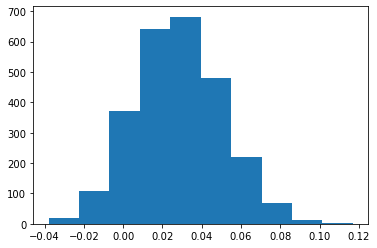

In [82]:
plt.hist(diffmat.mean(axis=0).flatten())

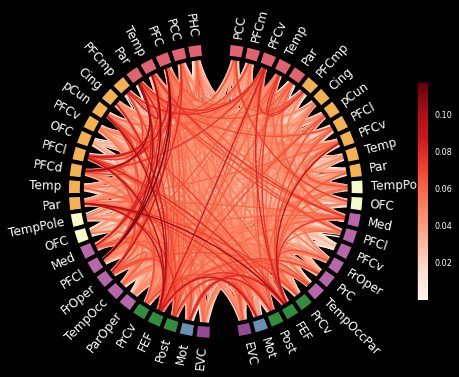

In [83]:
dplot = diffmat.mean(axis=0)
dplot[dplot<0]=np.nan
plot_connGraph(dplot,colormap='Reds')

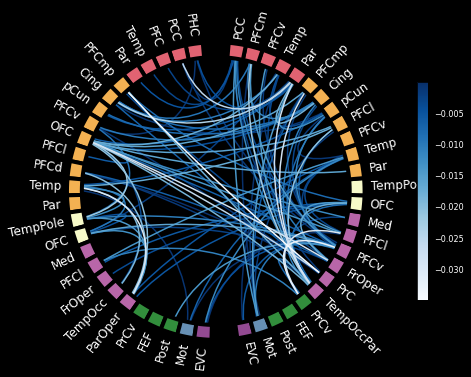

In [84]:
dplot = diffmat.mean(axis=0)
dplot[dplot>0]=np.nan
plot_connGraph(dplot,colormap='Blues')

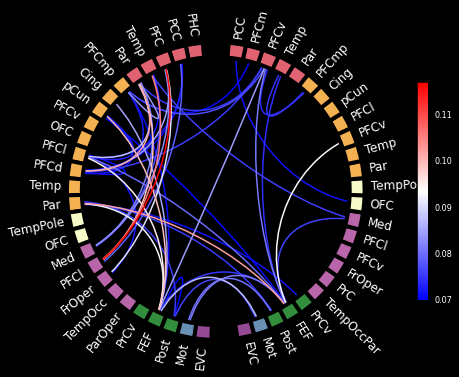

In [85]:
plot_connGraph(diffmat.mean(axis=0),colormap='bwr',n_lines=50)

In [86]:
from scipy.cluster.hierarchy import optimal_leaf_ordering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage

In [87]:
temp = squareform(vec[:,0])

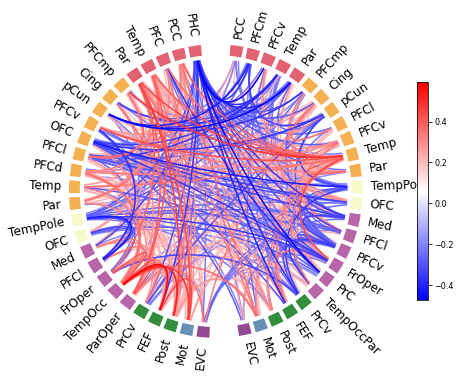

(<Figure size 576x576 with 2 Axes>, <PolarAxesSubplot:>)

In [88]:
vec = r03
mat1 = squareform(vec[:,0])
mat1[squareform(vec[:,1])>.05/(1275*10)] = np.nan

plot_mat = mat1
plot_lbls = rnames

I = np.hstack((np.arange(25,-1,-1),np.arange(26,51,1)))
#I = hierarchy.leaves_list(optimal_leaf_ordering(linkage(squareform(vec[:,0])),get_triu(squareform(vec[:,0]))))

plot_mat = plot_mat[I,:][:,I]
plot_lbls = np.array(plot_lbls)[I]

net_colors = dict()
net_colors['Vis'] = np.array((147,74,146))/ 255
net_colors['SomMot'] = np.array((103,144,180))/ 255
net_colors['DorsAttn'] = np.array((50,142,60))/ 255
net_colors['SalVentAttn'] = np.array((184,102,169))/ 255
net_colors['Limbic'] = np.array((247,250,201))/ 255
net_colors['Cont'] = np.array((243,177,82))/ 255
net_colors['Default'] = np.array((225,99,114)) / 255

nets = np.array([val.split('-')[1] for val in plot_lbls])
rois = np.array([val.split('-')[2] for val in plot_lbls])

node_colors = np.array([net_colors[net] for net in nets ])

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, 26])


#fig,ax = plt.subplots(1,1,figsize=(10,10))
_plot_connectivity_circle(con=plot_mat,
        node_names=rois,
        indices=None,
        n_lines=None,
        node_angles=node_angles,
        node_width=None,
        node_height=None,
        node_colors=node_colors,
        facecolor='white',
        textcolor='black',
        node_edgecolor='white',
        linewidth=1.5,
        colormap='bwr',
        vmin=None,
        vmax=None,
        colorbar=True,
        title=None,
        colorbar_size=.5,
        colorbar_pos=None,
        fontsize_title=12,
        fontsize_names=12,
        fontsize_colorbar=8,
        padding=2.0,
        ax=None,
        interactive=True,
        node_linewidth=4.0,
        show=True)

/data/aglinska/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/aglinska/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 14.,  53., 101.,   0.,   0.,   0., 127.,  62.,  14.,   3.]),
 array([-0.47168834, -0.36531976, -0.25895117, -0.15258259, -0.046214  ,
         0.06015458,  0.16652317,  0.27289175,  0.37926034,  0.48562893,
         0.59199751]),
 <BarContainer object of 10 artists>)

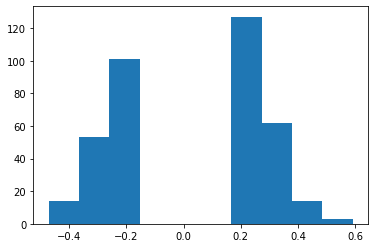

In [89]:
plt.hist(get_triu(mat1))

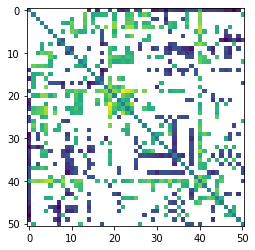

In [90]:
plt.imshow(mat1[I,:][:,I])

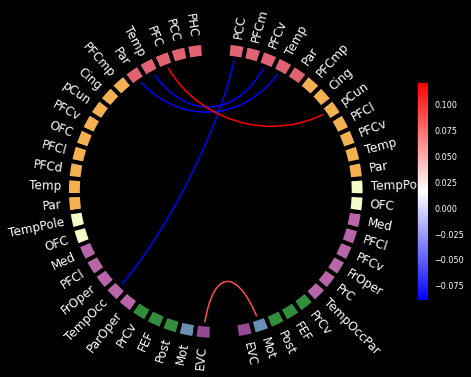

(<Figure size 576x576 with 2 Axes>, <PolarAxesSubplot:>)

In [91]:
vec = reducer.components_[5,:]
mat1 = squareform(vec)
#mat1[squareform(vec[:,1])>.05/(1275*10)] = np.nan

plot_mat = mat1
plot_lbls = rnames

I = np.hstack((np.arange(25,-1,-1),np.arange(26,51,1)))
#I = hierarchy.leaves_list(optimal_leaf_ordering(linkage(squareform(vec[:,0])),get_triu(squareform(vec[:,0]))))

plot_mat = plot_mat[I,:][:,I]
plot_lbls = np.array(plot_lbls)[I]

net_colors = dict()
net_colors['Vis'] = np.array((147,74,146))/ 255
net_colors['SomMot'] = np.array((103,144,180))/ 255
net_colors['DorsAttn'] = np.array((50,142,60))/ 255
net_colors['SalVentAttn'] = np.array((184,102,169))/ 255
net_colors['Limbic'] = np.array((247,250,201))/ 255
net_colors['Cont'] = np.array((243,177,82))/ 255
net_colors['Default'] = np.array((225,99,114)) / 255

nets = np.array([val.split('-')[1] for val in plot_lbls])
rois = np.array([val.split('-')[2] for val in plot_lbls])

node_colors = np.array([net_colors[net] for net in nets ])

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, 26])


#fig,ax = plt.subplots(1,1,figsize=(10,10))
_plot_connectivity_circle(con=plot_mat,
        node_names=rois,
        indices=None,
        n_lines=5,
        node_angles=node_angles,
        node_width=None,
        node_height=None,
        node_colors=node_colors,
        facecolor='black',
        textcolor='white',
        node_edgecolor='black',
        linewidth=1.5,
        colormap='bwr',
        vmin=None,
        vmax=None,
        colorbar=True,
        title=None,
        colorbar_size=.5,
        colorbar_pos=None,
        fontsize_title=12,
        fontsize_names=12,
        fontsize_colorbar=8,
        padding=2.0,
        ax=None,
        interactive=True,
        node_linewidth=4.0,
        show=True)

In [92]:
data.keys()

dict_keys(['Z_mu', 'Z_sigma', 'Z', 'S_mu', 'S_sigma', 'S', 'Z_sample100', 'S_sample100', 'recon_td_mu', 'recon_asd_mu', 'recon_twin_mu', 'recon_td_samples', 'recon_asd_samples', 'recon_twin_samples', 'Z_asd_sample10', 'S_asd_sample10'])

In [93]:
df.columns

Index(['Unnamed: 0', 'participant_id', 'diag', 'age', 'sex', 'fiq', 'site',
       'DSMIV', 'ados_total', 'ados_social', 'ados_comm', 'ados_rrb',
       'dataset', 'dataset_id', 'site_id', 'sites_bal'],
      dtype='object')

In [94]:
!date

Thu May 12 06:42:08 EDT 2022
